# Applications of Boltzmann generators - System 1: Double-well potential

## Section 1. Introduction: system of interest

To obtain a general sense about how Boltzmann generators work and how we can apply it to sample equilibrium states of many-body system, here we start with the simplest toy model, the double-well potential. Before we acquire the training data set, let's first visualize the double-well potential, which can be expressed as:
$$u({\bf x})=u(x_{1}, x_{2}) = ax_{1}^{4}-bx_{1}^{2}+cx_{1}+dx_{2}^{2}$$
To reproduce the data in the ["Boltzmann generator paper"](https://science.sciencemag.org/content/365/6457/eaaw1147) by Noe et al., we adopted $a=1,\;b=6, \; c=1, \;d=1 $. As the name suggests, the double-well potential has two energy minima, whose coordinates can be obtained by solving the following equations:
$$\frac{\partial u}{\partial x_{1}} = 4x^{3}-12x+1=0, \;\frac{\partial u}{\partial x_{2}}=x_{2}=0$$
As a result, the coordinates of the three stationary points are $(-1.7723, 0, -10.7524)$, $(0.08253, 0, 0.0417)$, and $(1.6888, 0, -7.2893)$, which are the global minimum, the saddle ppoint, and the local minimum, respectively.

To visualize the potential surface and check the positions of the minimum, we first import all the packages needed for this notebook and set the random seed as 20200423 to ensure reproducible results across different executions of the code.

In [153]:
import torch
from torch import nn
from torch.nn import functional as F
 
 
class MLP1(nn.Sequential):
    def __init__(self, dims):
        layers = []
        for i, dim in enumerate(dims[:-1]):
            layers.append(nn.Linear(dim, dims[i + 1]))
            if i != len(dims) - 1:
                layers.append(nn.ReLU())
        super().__init__(*layers)
        
class MLP2(nn.Module):
    def __init__(self, dims):
        super().__init__()
        layers = []
        for i, dim in enumerate(dims[:-1]):
            layers.append(nn.Linear(dim, dims[i + 1]))
            if i != len(dims) - 1:
                layers.append(nn.ReLU())
        self.layers = nn.Sequential(*layers)
   
    def forward(self, x):
        return self.layers(x)

In [154]:
model1 = MLP1([2, 5, 5, 2]) # or MLP2([2, 5, 5])
model2 = MLP2([2, 5, 5, 2])
print(model1)
print(model2)

MLP1(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=2, bias=True)
  (5): ReLU()
)
MLP2(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=2, bias=True)
    (5): ReLU()
  )
)


In [147]:
nn.Sequential(model1)

Sequential(
  (0): MLP1(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=2, bias=True)
    (5): ReLU()
  )
)

In [140]:
model2[0]

TypeError: 'MLP2' object is not subscriptable

In [146]:
s_net()

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=2, bias=True)
  (5): Tanh()
)

In [71]:
t = model2._modules['layers']


In [74]:
t[0].weight

Parameter containing:
tensor([[-0.3369, -0.2042],
        [ 0.7028, -0.1954],
        [-0.3117,  0.2382],
        [ 0.4016, -0.5582],
        [ 0.0721,  0.7054]], requires_grad=True)

In [73]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import warnings
import torch 
from torch import distributions
from torch import nn
from torch.utils import data
from tqdm.auto import tqdm
from sklearn import datasets
warnings.filterwarnings('ignore')
sys.path.insert(1, '../')  # so the system can locate the library folder
sys.path.insert(1, '../Library')
import Library.potentials as potentials
import Library.generator as generator
import Library.sampling as sampling
import Library.training as training
import Library.density_estimator as density_estimator

In [2]:
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

The coordinates of the minima are: [-1.7723034076580755, 0.0] and [1.6887758209615107, 0.0].
The coordinate of the saddle point is: [0.08352758669656443, 0.0].
The energy difference between the two local minima is: 3.463.
The height of energy barrier is: 10.794.


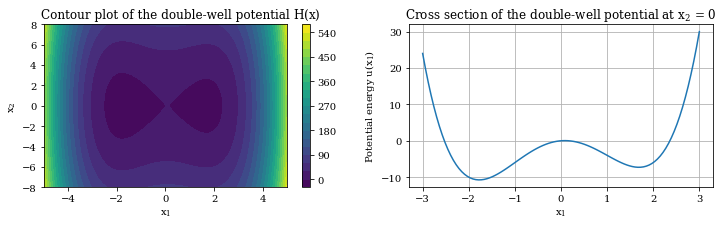

In [3]:
doublewell = potentials.DoubleWellPotential(a=1, b=6, c=1, d=1)  #  defaults = {"a": 1, "b": 6, "c": 1, "d": 1}
doublewell.plot_samples()  # another choice: a=0.25, b=1.5, c=1, d=1
print('The coordinates of the minima are: %s and %s.' % (list(doublewell.min_left), list(doublewell.min_right)))
print('The coordinate of the saddle point is: %s.' % list(doublewell.saddle))
print('The energy difference between the two local minima is: %5.3f.' % doublewell.e_diff)
print('The height of energy barrier is: %5.3f.' % doublewell.barrier)
plt.savefig('../Project/Pictures/DWP.png', dpi=600)

As shown above, there are two metastable states in the potential energy surface and the slow motion of crossing the energy barrier between them lies in th direction of $x_{1}$, given the fact that all three stationary points are all on the same line $x_{2}=0$. From the cross section of the potential at $x_{2}=0$, we can see that the minimum in the well on the left (state 1) has a smaller potental energy than the one in the right well (state 2). The energy difference between them is about 3.463 and the energy barrier (the difference between the global minimum and the saddle point) is 10.794.

The goals of applying a Boltzmann generator to this system include:
- Use a trained Boltzmann generator to generate configurations at both states.
- Use the Boltzmann generator to map out a possible reaction path between the two metastable states.
- Use the Boltzmann generator to compute the free energy as a function of the chosen reaction coordinate, which is $x_{1}$ in this case.
- Compute the free energy difference between the to metastable states.
- Assess the generator with differnt loss functions (ML, KL and ML+KL) in terms of accuracy.

## Section 2. Acquisition of the input dataset from Metropolis Monte Carlo simulations

As descried in our project paper, we have to extract samples from the configuration space ($x$ space, real space) to train the inverse generator network. To extract reasonable configurations, instead of randomly decide the coordinates of the configurations based on a Gaussian distribution, a better way is to run a Metropolis Monte Carlo simulation. Here, we use `sampling.MetropolisSampler` to run a Monte Carlo simulation for each minimum for 5000 steps. Since a Monte Carlo simulation is memoryless, each configuration are uncorrelated with each other. Combining the samples extracted from the two Monte Carlo simulation, we obtain a training data set of size 10000 samples in the configuraiton sapce. Samples from different minimum are in different colors, as shown in the figure below. 

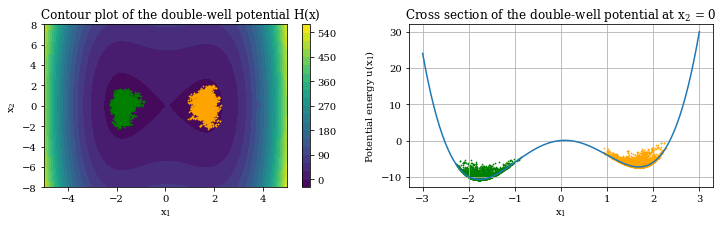

In [4]:
MCsampler1 = sampling.MetropolisSampler(doublewell, doublewell.min_left)
MCsampler1.run(doublewell.min_left, 5000)
samples1 = MCsampler1.xtraj

MCsampler2 = sampling.MetropolisSampler(doublewell, doublewell.min_right)
MCsampler2.run(doublewell.min_right, 5000)
samples2 = MCsampler2.xtraj

fig = doublewell.plot_samples(samples1)
fig = doublewell.plot_samples(samples2, fig, 'orange')
plt.savefig('../Project/Pictures/DWP_samples.png', dpi=600)

Another way to visualize the samples is to plot the distributions of the potential energy and the displacement in $x_{1}$ direction. As shown below, samples from State 1 and State 2 are colored in blue and red, respectively. From the histogram of potential energy, we can see that samples with a lower potential energy are dominant compared to samples with a higher potential energy. From the middle and the right panel, we can observe that the peaks of the distributions are also of minimal potential energies, which justify Monte Carlo simulations as a measure of extracting configurations in the $x$ space.

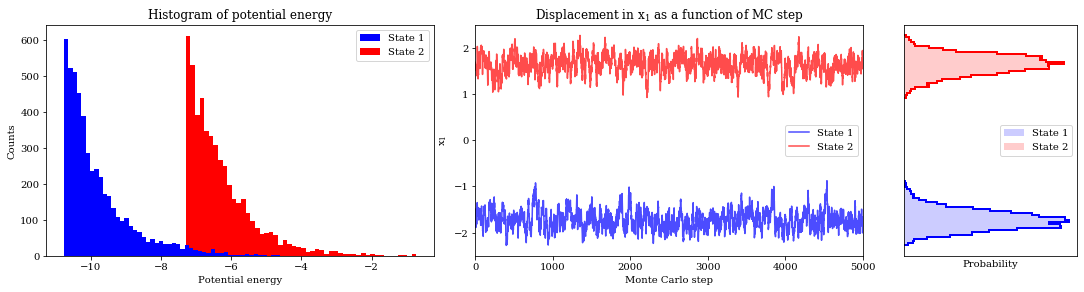

In [5]:
fig = plt.figure(figsize=(15, 4))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4), colspan=1)

ax1.hist(doublewell.get_energy([samples1[:, 0], samples1[:, 1]]), bins=50, color='blue', label='State 1', zorder=10)
ax1.hist(doublewell.get_energy([samples2[:, 0], samples2[:, 1]]), bins=50, color='red', label='State 2', zorder=0)
ax1.set_xlabel('Potential energy')
ax1.set_ylabel('Counts')
ax1.set_title('Histogram of potential energy')
ax1.legend()

ax2.plot(samples1[:, 0], color='blue', alpha=0.7, label='State 1')
ax2.plot(samples2[:, 0], color='red', alpha=0.7, label='State 2')
ax2.set_xlim(0, len(samples1))
ax2.set_ylim(-2.5, 2.5)
ax2.set_xlabel('Monte Carlo step')
ax2.set_ylabel('$ x_{1} $')
ax2.set_title('Displacement in $x_{1}$ as a function of MC step')
ax2.legend()

ax3.hist(samples1[:, 0], 30, orientation='horizontal', histtype='stepfilled', color='blue', alpha=0.2, label='State 1');
ax3.hist(samples1[:, 0], 30, orientation='horizontal', histtype='step', color='blue', linewidth=2);
ax3.hist(samples2[:, 0], 30, orientation='horizontal', histtype='stepfilled', color='red', alpha=0.2, label='State 2');
ax3.hist(samples2[:, 0], 30, orientation='horizontal', histtype='step', color='red', linewidth=2);
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_ylim(-2.5, 2.5)
ax3.set_xlabel('Probability')
ax3.legend()

fig.tight_layout(pad=0.5)
plt.savefig('../Project/Pictures/DWP_MC_histo.png', dpi=600)

Here, we combine the samples from different minimum into one training data set `x_samples` and shuffle the data.

In [6]:
x_samples = np.concatenate((samples1, samples2))  # the training dataset
np.random.shuffle(x_samples) # shuffle rows of data

## Section 3. Construction of a Boltzmann generator
### Section 3-1. The architecture of a Boltzmann generator

<center><img src=https://i.imgur.com/qgPKzrn.png width=600></center>
</br>

The architecture of a Boltzmann generator is shown in the figure above, which was reproduced from Figure 1. in the Boltzmann generator paper. To build a Boltzmann generator, we first have to specify parameters as below, including the number of NVP blocks, the number of hidden layers in each block and the number of nodes in each hidden layer, etc. Except for the number of iterations, we use the same parameters in the next cell for all the cases explored in this notebook.

s =  tensor([[ 0.3643, -0.3121],
        [-0.1371,  0.3319],
        [-0.6657,  0.4241],
        [-0.1455,  0.3597],
        [ 0.0983, -0.0866]], grad_fn=<SliceBackward>)
t =  tensor([[ 0.5404,  0.3247],
        [-0.3355, -0.1006],
        [-0.6046, -0.2065],
        [ 0.1116,  0.6818],
        [-0.6950, -0.1588]], grad_fn=<SliceBackward>)
start
s =  tensor([[ 0.3643, -0.3121],
        [-0.1371,  0.3319],
        [-0.6657,  0.4241],
        [-0.1455,  0.3597],
        [ 0.0983, -0.0866]], grad_fn=<SliceBackward>)
t =  tensor([[ 0.5404,  0.3247],
        [-0.3355, -0.1006],
        [-0.6046, -0.2065],
        [ 0.1116,  0.6818],
        [-0.6950, -0.1588]], grad_fn=<SliceBackward>)
s =  tensor([[ 0.3643, -0.3121],
        [-0.1371,  0.3319],
        [-0.6657,  0.4241],
        [-0.1455,  0.3597],
        [ 0.0983, -0.0866]], grad_fn=<SliceBackward>)
t =  tensor([[ 0.5404,  0.3247],
        [-0.3355, -0.1006],
        [-0.6046, -0.2065],
        [ 0.1116,  0.6818],
        [-0.6950, -0.1

Total loss: 0.07895103842020035


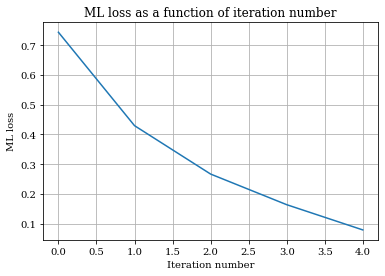

In [7]:
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

params_ML = {"n_blocks": 3, "dimension": 2, "n_nodes": 100, "n_layers": 3,
               "n_iterations": 5, "batch_size": 1000, "LR": 0.001, "prior_sigma": 1}
w_loss = [1, 0, 0]

# for drawing samples from the latent space later
prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2)) 

BoltzmannGenerator_ML = training.BoltzmannGenerator(model_params=params_ML)
model_ML = BoltzmannGenerator_ML.build(doublewell)
if os.path.isfile('Trained_models/DoubleWell/model_ML') is False:  
    print("Loading the trained model ...")
    model_ML, loss = BoltzmannGenerator_ML.load(model_ML, 'Trained_models/DoubleWell/model_ML')
else:   
    print("Training model_ML ...")
    BoltzmannGenerator_ML.train(model_ML, w_loss, x_samples=x_samples)
    BoltzmannGenerator_ML.save(model_ML, 'Trained_models/DoubleWell/model_ML')
    loss = BoltzmannGenerator_ML.loss_list
    
# plot the loss function as a function of iteration
plt.figure()
plt.plot(range(len(loss)), loss)
plt.xlabel('Iteration number')
plt.ylabel('ML loss')
plt.title('ML loss as a function of iteration number')
plt.grid()
plt.savefig('../Project/Pictures/DWP_training_ML_loss.png', dpi=600)

In [7]:
from scipy.stats import multivariate_normal
def binormal_contour():
    x, y = np.mgrid[-3:3:.01, -3:3:.01]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x; pos[:, :, 1] = y
    rv = multivariate_normal([0, 0], [[1, 0], [0, 1]])
    
    plt.contourf(x, y, rv.pdf(pos), 20)
    plt.xlabel('$ z_{1} $')
    plt.ylabel('$ z_{2} $')
    plt.title('Bivariate normal distribution')
    clb = plt.colorbar()
    clb.ax.set_title(r'$P(z)$')
    
    ax = plt.gca()
    ax.set_aspect('equal')

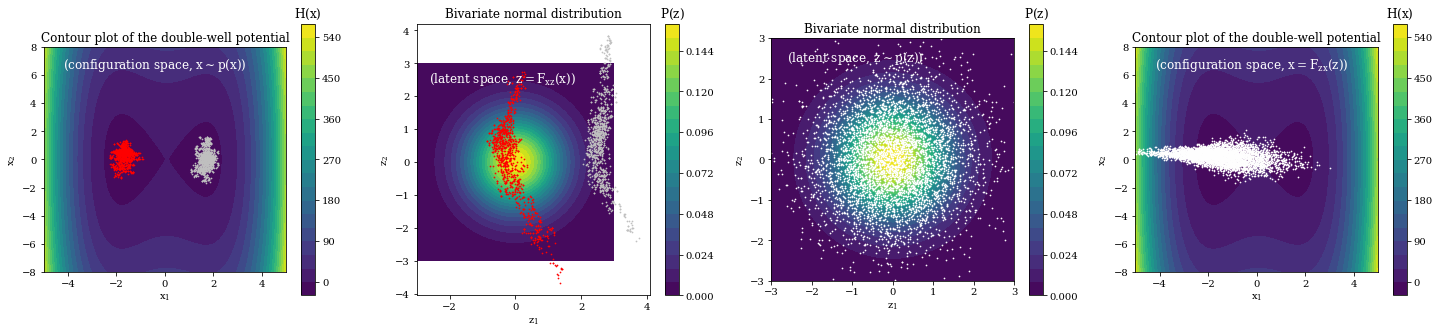

In [9]:
fig = plt.subplots(1, 4, figsize=(25, 5))

# First subplot: samples drawn from the configuration space
plt.subplot(1, 4, 1)
doublewell.plot_FES()
plt.scatter(samples1[:, 0], samples1[:, 1], color='red', s=0.5)
plt.scatter(samples2[:, 0], samples2[:, 1], color='silver', s=0.5)
plt.annotate('(configuration space, $ x \sim p(x) $)', xy=(0, 0), xytext=(-4.2, 6.5), color='white', size='12')
ax = plt.gca()
ax.set_aspect(0.58)


# Second subplot: transform configuration samples to latent samples using a trained inversed generator
z1, _, z1_list = model_ML.inverse_generator(torch.from_numpy(samples1.astype('float32')), process=True)
z2, _, z2_list = model_ML.inverse_generator(torch.from_numpy(samples2.astype('float32')), process=True)
z1 = z1.detach().numpy()
z2 = z2.detach().numpy()

plt.subplot(1, 4, 2)
binormal_contour()
plt.scatter(z1[:, 0], z1[:, 1], color='red', s=0.5)
plt.scatter(z2[:, 0], z2[:, 1], color='silver', s=0.5)
plt.annotate('(latent space, $ z = F_{xz}(x) $)', xy=(0, 0), xytext=(-2.625, 2.4375), color='white', size='12')
#plt.xlim([-3, 3])
#plt.ylim([-3, 3])


# Third subplot: draw 2000 samples from the prior Gaussian distribution
z_samples = prior.sample_n(5000)
z_samples = z_samples.detach().numpy()  

plt.subplot(1, 4, 3)
binormal_contour()
plt.scatter(z_samples[:, 0], z_samples[:, 1], color='white', s=0.5)
plt.annotate('(latent space, $ z \sim p(z) $)', xy=(0, 0), xytext=(-2.625, 2.4375), color='white', size='12')
plt.xlim([-3, 3])
plt.ylim([-3, 3])

# fourth subplot: transform the latent samples back to the configuration space using a generator
x_generated, _, x_list = model_ML.generator(torch.from_numpy(z_samples), process=True)
x_generated = x_generated.detach().numpy()

plt.subplot(1, 4, 4)
doublewell.plot_FES()
plt.scatter(x_generated[:, 0], x_generated[:, 1], color='white', s=0.5)
plt.annotate('(configuration space, $ x = F_{zx}(z) $)', xy=(0, 0), xytext=(-4.2, 6.5), color='white', size='12')
plt.xlim([-5, 5])
plt.ylim([-8, 8])
ax = plt.gca()
ax.set_aspect(0.58)

plt.savefig('../Project/Pictures/DWP_ML_result.png', dpi=600)

In [7]:
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

layer = []
a = nn.Linear(2, 100)
a.weight[:5]

tensor([[ 0.3643, -0.3121],
        [-0.1371,  0.3319],
        [-0.6657,  0.4241],
        [-0.1455,  0.3597],
        [ 0.0983, -0.0866]], grad_fn=<SliceBackward>)

In [9]:
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

s_net = lambda: nn.Sequential(nn.Linear(2, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 2), nn.Tanh())
s = torch.nn.ModuleList([s_net() for _ in range(len(mask))]) 
s[0][0].weight[:5]

NameError: name 'n_blocks' is not defined

tensor([[ 0.3643, -0.3121],
        [-0.1371,  0.3319],
        [-0.6657,  0.4241],
        [-0.1455,  0.3597],
        [ 0.0983, -0.0866]], grad_fn=<SliceBackward>)

In [10]:
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

params_test1 = {"n_blocks": 3, "dimension": 2, "n_nodes": 100, "n_layers": 3,
               "n_iterations": 5, "batch_size": 1000, "LR": 0.001, "prior_sigma": 1}
w_loss = [1, 0, 0]

BoltzmannGenerator_ML = training.BoltzmannGenerator(model_params=params_test1)
model_test1 = BoltzmannGenerator_ML.build(doublewell)

test
tensor([[ 0.3643, -0.3121],
        [-0.1371,  0.3319],
        [-0.6657,  0.4241],
        [-0.1455,  0.3597],
        [ 0.0983, -0.0866]], grad_fn=<SliceBackward>)
test
tensor([[ 0.5404,  0.3247],
        [-0.3355, -0.1006],
        [-0.6046, -0.2065],
        [ 0.1116,  0.6818],
        [-0.6950, -0.1588]], grad_fn=<SliceBackward>)
tensor([[ 0.3643, -0.3121],
        [-0.1371,  0.3319],
        [-0.6657,  0.4241],
        [-0.1455,  0.3597],
        [ 0.0983, -0.0866]], grad_fn=<SliceBackward>)


In [10]:
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

n_blocks = 3     # number of NVP blocks
dimension = 2    # dimensionality of the probability distributios (in real sapce and latent space)
n_hidden = 100   # number of nodes in each hidden layer
l_hidden = 3     # number of hidden layers (unused)
n_iteration = 5
batch_size = 1000
LR = 0.001     # learning rate
prior_sigma = 1


s_net = lambda: nn.Sequential(nn.Linear(2, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 2), nn.Tanh())
t_net = lambda: nn.Sequential(nn.Linear(2, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 2))
mask = torch.from_numpy(np.array([[0, 1], [1, 0]] * n_blocks).astype(np.float32)) 
prior = distributions.MultivariateNormal(torch.zeros(dimension), torch.eye(dimension) * prior_sigma) 

"""
t = torch.nn.ModuleList([t_net() for _ in range(6)]) 
s = torch.nn.ModuleList([s_net() for _ in range(6)])

print('before')
print("s' = ", s[0][0].weight[:5])
print("t' = ", t[0][0].weight[:5])
print('\n')
"""


model_test2 = generator.RealNVP(s_net, t_net, mask, prior, doublewell, (2,))

start
s =  tensor([[-0.3868, -0.5737],
        [-0.5892,  0.4150],
        [-0.5880, -0.1430],
        [ 0.0852, -0.5400],
        [ 0.4941,  0.4677]], grad_fn=<SliceBackward>)
t =  tensor([[ 0.3643, -0.3121],
        [-0.1371,  0.3319],
        [-0.6657,  0.4241],
        [-0.1455,  0.3597],
        [ 0.0983, -0.0866]], grad_fn=<SliceBackward>)
s =  tensor([[-0.3868, -0.5737],
        [-0.5892,  0.4150],
        [-0.5880, -0.1430],
        [ 0.0852, -0.5400],
        [ 0.4941,  0.4677]], grad_fn=<SliceBackward>)
t =  tensor([[ 0.3643, -0.3121],
        [-0.1371,  0.3319],
        [-0.6657,  0.4241],
        [-0.1455,  0.3597],
        [ 0.0983, -0.0866]], grad_fn=<SliceBackward>)


In [7]:
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
params_ML = {"n_blocks": 3, "dimension": 2, "n_nodes": 100, "n_layers": 3,
               "n_iterations": 5, "batch_size": 1000, "LR": 0.001, "prior_sigma": 1}
w_loss = [1, 0, 0]

# for drawing samples from the latent space later
prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2)) 

BoltzmannGenerator_ML = training.BoltzmannGenerator(model_params=params_ML)
model_ML = BoltzmannGenerator_ML.build(doublewell)
if os.path.isfile('Trained_models/DoubleWell/model_ML') is False:  
    print("Loading the trained model ...")
    model_ML, loss = BoltzmannGenerator_ML.load(model_ML, 'Trained_models/DoubleWell/model_ML')
else:   
    print("Training model_ML ...")
    BoltzmannGenerator_ML.train(model_ML, w_loss, x_samples=x_samples)
    BoltzmannGenerator_ML.save(model_ML, 'Trained_models/DoubleWell/model_ML')

NameError: name 'batch_size' is not defined

tensor([[ 0.3643, -0.3121],
        [-0.1371,  0.3319],
        [-0.6657,  0.4241],
        [-0.1455,  0.3597],
        [ 0.0983, -0.0866]], grad_fn=<SliceBackward>)


ML loss: 0.32087382674217224


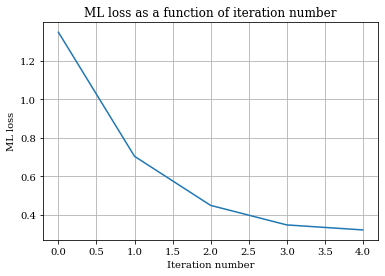

In [13]:
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
n_blocks = 3     # number of NVP blocks
dimension = 2    # dimensionality of the probability distributios (in real sapce and latent space)
n_hidden = 100   # number of nodes in each hidden layer
l_hidden = 3     # number of hidden layers (unused)
n_iteration = 5
batch_size = 1000
LR = 0.001     # learning rate
prior_sigma = 1
s_net = lambda: nn.Sequential(nn.Linear(2, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 2), nn.Tanh())
t_net = lambda: nn.Sequential(nn.Linear(2, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 2))
mask = torch.from_numpy(np.array([[0, 1], [1, 0]] * n_blocks).astype(np.float32)) 
prior = distributions.MultivariateNormal(torch.zeros(dimension), torch.eye(dimension) * prior_sigma) 

model_test2 = generator.RealNVP(s_net, t_net, mask, prior, doublewell, (2,))
optimizer = torch.optim.Adam([p for p in model_test2.parameters() if p.requires_grad==True], lr=LR) 
training_set = x_samples.astype('float32')
subdata = data.DataLoader(dataset=training_set, batch_size=batch_size)  # use trainloader.dataset to check the data
batch = torch.from_numpy(subdata.dataset)   # note that subdata.dataset is a numpy array


loss_list = []
for i in tqdm(range(n_iteration)):
    loss = model_test2.loss_ML(batch)
    loss_list.append(loss.item())  # convert from 1-element tensor to scalar

    # start training
    optimizer.zero_grad() # Set grads to zero so that PyTorch will not accumulate gradients during backpropagation
    loss.backward(retain_graph=True)
    optimizer.step()   # check https://tinyurl.com/y8o2y5e7 for more info
    tqdm.write("ML loss: %s" % loss.item(), end="\r")

plt.figure()
plt.plot(range(n_iteration), loss_list)
plt.xlabel('Iteration number')
plt.ylabel('ML loss')
plt.title('ML loss as a function of iteration number')
plt.grid()
plt.savefig('../Project/Pictures/DWP_training_ML_loss.png', dpi=600)

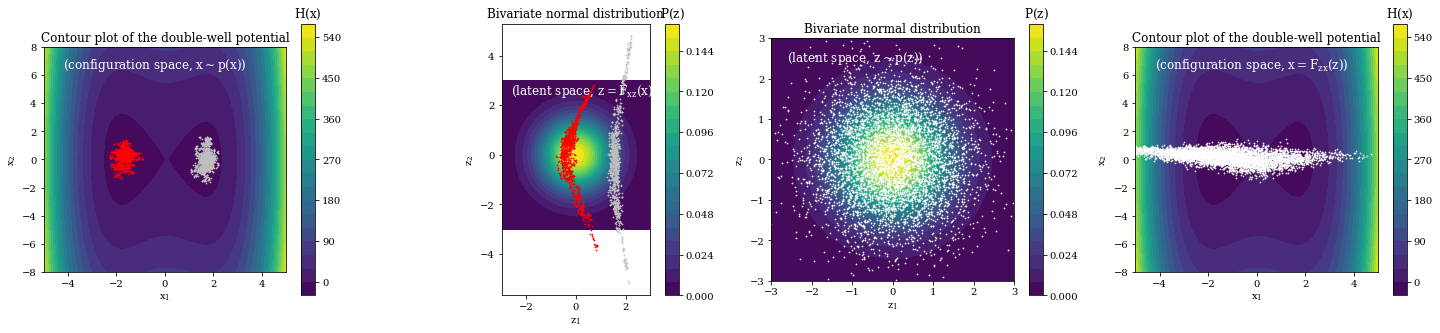

In [12]:
fig = plt.subplots(1, 4, figsize=(25, 5))

# First subplot: samples drawn from the configuration space
plt.subplot(1, 4, 1)
doublewell.plot_FES()
plt.scatter(samples1[:, 0], samples1[:, 1], color='red', s=0.5)
plt.scatter(samples2[:, 0], samples2[:, 1], color='silver', s=0.5)
plt.annotate('(configuration space, $ x \sim p(x) $)', xy=(0, 0), xytext=(-4.2, 6.5), color='white', size='12')
ax = plt.gca()
ax.set_aspect(0.58)


# Second subplot: transform configuration samples to latent samples using a trained inversed generator
z1, _, z1_list = model_test2.inverse_generator(torch.from_numpy(samples1.astype('float32')), process=True)
z2, _, z2_list = model_test2.inverse_generator(torch.from_numpy(samples2.astype('float32')), process=True)
z1 = z1.detach().numpy()
z2 = z2.detach().numpy()

plt.subplot(1, 4, 2)
binormal_contour()
plt.scatter(z1[:, 0], z1[:, 1], color='red', s=0.5)
plt.scatter(z2[:, 0], z2[:, 1], color='silver', s=0.5)
plt.annotate('(latent space, $ z = F_{xz}(x) $)', xy=(0, 0), xytext=(-2.625, 2.4375), color='white', size='12')
#plt.xlim([-3, 3])
#plt.ylim([-3, 3])


# Third subplot: draw 2000 samples from the prior Gaussian distribution
z_samples = prior.sample_n(5000)
z_samples = z_samples.detach().numpy()  

plt.subplot(1, 4, 3)
binormal_contour()
plt.scatter(z_samples[:, 0], z_samples[:, 1], color='white', s=0.5)
plt.annotate('(latent space, $ z \sim p(z) $)', xy=(0, 0), xytext=(-2.625, 2.4375), color='white', size='12')
plt.xlim([-3, 3])
plt.ylim([-3, 3])

# fourth subplot: transform the latent samples back to the configuration space using a generator
x_generated, _, x_list = model_test2.generator(torch.from_numpy(z_samples), process=True)
x_generated = x_generated.detach().numpy()

plt.subplot(1, 4, 4)
doublewell.plot_FES()
plt.scatter(x_generated[:, 0], x_generated[:, 1], color='white', s=0.5)
plt.annotate('(configuration space, $ x = F_{zx}(z) $)', xy=(0, 0), xytext=(-4.2, 6.5), color='white', size='12')
plt.xlim([-5, 5])
plt.ylim([-8, 8])
ax = plt.gca()
ax.set_aspect(0.58)

plt.savefig('../Project/Pictures/DWP_ML_result.png', dpi=600)

In [12]:
batch

tensor([[-2.0356, -0.6302],
        [-1.7727,  0.4867],
        [ 1.6363, -0.0808],
        ...,
        [-1.5835,  1.0843],
        [ 1.5055,  0.3148],
        [-1.9320,  0.0367]])

In [19]:
t = torch.nn.ModuleList([t_net() for _ in range(len(mask))]) 
s = torch.nn.ModuleList([s_net() for _ in range(len(mask))]) 
print(t[0])
print(s[0])

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=2, bias=True)
)
Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=2, bias=True)
  (5): Tanh()
)


In [51]:
n_blocks = 3     # number of NVP blocks
dimension = 2    # dimensionality of the probability distributios (in real sapce and latent space)
n_hidden = 100   # number of nodes in each hidden layer
l_hidden = 3     # number of hidden layers (unused)
n_iteration = 200
batch_size = 1000
LR = 0.001     # learning rate
prior_sigma = 1

With parameters above, we are able to define important inputs to initialize the class `RealNVP` as follows:

In [52]:
s_net = lambda: nn.Sequential(nn.Linear(2, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 2), nn.Tanh())
t_net = lambda: nn.Sequential(nn.Linear(2, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 2))
mask = torch.from_numpy(np.array([[0, 1], [1, 0]] * n_blocks).astype(np.float32)) 
prior = distributions.MultivariateNormal(torch.zeros(dimension), torch.eye(dimension) * prior_sigma) 

Below are some notes about the some of the argument to initialize `RealNVP`:
- **Prior probability distribution in the latent space** (`prior`):
    - ``prior = distributions.MultivariateNormal(torch.zeros(dimension), torch.eye(dimension)``
    - Note that our double-well potential is a 2D function, so the Gaussian distribution must be bivariate. (`dimension=2`)
    - `torch.zeros(2)`: The mean of the bivariate normal distribution, which is a 1-by-2 zero matrix in this case.
    - `torch.eye(2)`: The covariance matrix of the bivariate normal distribution, which is an 2-by-2 identity matrix.
    - To generate 500 samples from the prior distribution, use `prior.sample([500])`.
- **Masking shceme for affine coupling layers** (`mask`):
    - `masks = torch.from_numpy(np.array([[0, 1], [1, 0]] * n_blocks).astype(np.float32))`
    - In `__init__` function of `RealNVP` in `generator.py`, `self.mask = nn.Parameter(mask)` makes the mask as the module parameter. Note that `nn.Parameter` only takes in `torch.Tensor`. (Try printing `nn.Parameter(mask)`.)
- **Scaling and translation neural networksin the coupling layers** (`s_net` and `t_net`):
    - `torch.nn.Sequential`: A sequential container. Modules will be added to it in the order they are passed in the constructor. Alternatively, an ordered dict of modules can also be passed in.
    - In our case here, there are three hidden layers, which are all initialized by `nn.Linear` module, which applies a linear transofmration to the incoming data: $y = x A^{T} + b$. (Note that `nn.Linear` module automatically initializes the weights randomly.)
    - The dimensions of the input and the output of the networks should be 2, which correspond to the dimensionality of the proability distribution. Therefore, the number of input nodes of the first layer and the output node of the last layer are both 2.
    - For `s_net`, except that the last hidden layer uses hyperbolic tangent, other layers all use ReLU as the activation function. However, for `t_net`, there is no activation function for the last layer.
    - In `__init__` function of `RealNVP`, we use `nn.ModuleList`, which is like a Python list used to store a desired number of `nn.Module`’s as `self.t = torch.nn.ModuleList([nett() for _ in range(len(mask))])`. 

In the Section 3.2, we will initialize a Boltzmann generator and train it. 

### Section 3-2. Crescent moons - a toy model to ensure the applicability of our Boltzmann generator

As describred in the original paper, a Boltzmann generator is basically a series of non volume-preseving (NVP) blocks which contain several affine coupling layers in each block. 



To constuct our own Boltzmann generators, we first followed the code provided by 

In the original paper, Noe et al. constructed Boltzmann generators using `tensorflow` and `keras`.


Extending and generalizing 





In [34]:
noisy_moons = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)

In [35]:
"""
# Load or build & train the model
model_crescent = generator.RealNVP(s_net, t_net, mask, prior, doublewell, (2,))

if os.path.isfile('Trained_models/model_crescent') is True:
    model_crescent.load_state_dict(torch.load('Trained_models/test'))
else:
    optimizer_test = torch.optim.Adam([p for p in model_crescent.parameters() if p.requires_grad==True], lr=LR) 
    training_set_test = noisy_moons.astype('float32')   # note we use samples in latent space here
    subdata_test = data.DataLoader(dataset=training_set_test, batch_size=batch_size)  # use trainloader.dataset to check the data
    batch_test = torch.from_numpy(subdata_test.dataset)   # note that subdata.dataset is a numpy array

    loss_list = []   # saving the loss as a function of iteration number 

    n_iteration = 200
    for i in tqdm(range(n_iteration)):
        z, logp = model_crescent.inverse_generator(torch.from_numpy(noisy_moons))
        loss = -(model_crescent.prior.log_prob(z) + logp).mean()
        loss_list.append(loss.item())  # convert from 1-element tensor to scalar

        # start training
        optimizer_test.zero_grad() # Set grads to zero so that PyTorch will not accumulate gradients during backpropagation
        loss.backward(retain_graph=True)
        optimizer_test.step()   # check https://tinyurl.com/y8o2y5e7 for more info
        print("ML loss: %s" % loss.item(), end="\r")

    plt.figure()
    plt.plot(range(n_iteration), loss_list)
    plt.xlabel('Iteration number')
    plt.ylabel('ML loss')
    plt.title('ML loss as a function of iteration number')
    plt.grid()
    plt.savefig('../Project/Pictures/DWP_training_ML_loss.png', dpi=600)

    # Save the trained model
    torch.save(model_crescent.state_dict(), 'Trained_models/model_crescent')
"""

'\n# Load or build & train the model\nmodel_crescent = generator.RealNVP(s_net, t_net, mask, prior, doublewell, (2,))\n\nif os.path.isfile(\'Trained_models/model_crescent\') is True:\n    model_crescent.load_state_dict(torch.load(\'Trained_models/test\'))\nelse:\n    optimizer_test = torch.optim.Adam([p for p in model_crescent.parameters() if p.requires_grad==True], lr=LR) \n    training_set_test = noisy_moons.astype(\'float32\')   # note we use samples in latent space here\n    subdata_test = data.DataLoader(dataset=training_set_test, batch_size=batch_size)  # use trainloader.dataset to check the data\n    batch_test = torch.from_numpy(subdata_test.dataset)   # note that subdata.dataset is a numpy array\n\n    loss_list = []   # saving the loss as a function of iteration number \n\n    n_iteration = 200\n    for i in tqdm(range(n_iteration)):\n        z, logp = model_crescent.inverse_generator(torch.from_numpy(noisy_moons))\n        loss = -(model_crescent.prior.log_prob(z) + logp).me

In [36]:
"""fig = plt.subplots(1, 4, figsize=(25, 5))

# First subplot: samples drawn from the configuration space
plt.subplot(1, 4, 1)
plt.scatter(noisy_moons[:, 0], noisy_moons[:, 1], color='blue', s=0.5) 
plt.title('Configuration space, $ x \sim p(x) $')
plt.xlabel('$ x_{1} $')
plt.ylabel('$ x_{2} $')
plt.grid()

# Second subplot: transform configuration samples to latent samples using a trained inversed generator
z1 = model_crescent.inverse_generator(torch.from_numpy(noisy_moons.astype('float32')))[0].detach().numpy()
plt.subplot(1, 4, 2)
plt.scatter(z1[:, 0], z1[:, 1], color='red', s=0.5)
plt.title('Latent space, $ z = F_{xz}(x) $')
plt.xlabel('$ z_{1} $')
plt.ylabel('$ z_{2} $')
plt.xlim([-1.25, 2.25])
plt.ylim([1.25,-0.75])
plt.grid()

# Third subplot: draw 2000 samples from the prior Gaussian distribution
z_samples = prior.sample_n(2000)
z_samples = z_samples.detach().numpy()  
plt.subplot(1, 4, 3)
plt.scatter(z_samples[:, 0], z_samples[:, 1], color='red', s=0.5)
plt.title('Latent space, $ z \sim p(z) $')
plt.xlabel('$ z_{1} $')
plt.ylabel('$ z_{2} $')
plt.grid()

# fourth subplot: transform the latent samples back to the configuration space using a generator
x_generated, log_R_zx = model_crescent.generator(torch.from_numpy(z_samples))
x_generated = x_generated.detach().numpy()
plt.subplot(1, 4, 4)
plt.scatter(x_generated[:, 0], x_generated[:, 1], color='blue', s=0.5)
plt.title('Configuration space, $ x = F_{zx}(z) $')
plt.xlabel('$ x_{1} $')
plt.ylabel('$ x_{2} $')
plt.xlim([-1.25, 2.25])
plt.ylim([1.25,-0.75])
plt.grid()

plt.savefig('../Project/Pictures/crescent_ML_result.png', dpi=600)
"""


"fig = plt.subplots(1, 4, figsize=(25, 5))\n\n# First subplot: samples drawn from the configuration space\nplt.subplot(1, 4, 1)\nplt.scatter(noisy_moons[:, 0], noisy_moons[:, 1], color='blue', s=0.5) \nplt.title('Configuration space, $ x \\sim p(x) $')\nplt.xlabel('$ x_{1} $')\nplt.ylabel('$ x_{2} $')\nplt.grid()\n\n# Second subplot: transform configuration samples to latent samples using a trained inversed generator\nz1 = model_crescent.inverse_generator(torch.from_numpy(noisy_moons.astype('float32')))[0].detach().numpy()\nplt.subplot(1, 4, 2)\nplt.scatter(z1[:, 0], z1[:, 1], color='red', s=0.5)\nplt.title('Latent space, $ z = F_{xz}(x) $')\nplt.xlabel('$ z_{1} $')\nplt.ylabel('$ z_{2} $')\nplt.xlim([-1.25, 2.25])\nplt.ylim([1.25,-0.75])\nplt.grid()\n\n# Third subplot: draw 2000 samples from the prior Gaussian distribution\nz_samples = prior.sample_n(2000)\nz_samples = z_samples.detach().numpy()  \nplt.subplot(1, 4, 3)\nplt.scatter(z_samples[:, 0], z_samples[:, 1], color='red', s=0.5)

## Section 4. Applying Boltzmann generators to double-well potential 

### Section 4-1. Training by the examples in the configuration space
According to Figure 1. in the Boltzmann generator paper, the steps of generating a sample in the configuration space using a Boltzmann generator are:
- **Step 1**: Generate samples from the probability distribution in the configuration space. (Done in Monte Carlo simulation in Section 2.)
- **Step 2**: Use the samples obtained in Step 1. to train the inverse generator $F_{xz}$ (or $G^{-1}$). (`inverse_generator` in `RealNVP`).
- **Step 3**: After the inverse generator is trained, generate samples from the prior distribution in the latent space (`latent_sampler` in `RealNVP`).
- **Step 4**: Use the samples obtained in Step 3 as the input to the generator $F_{zx}$ (or $G$). (`generator` in `RealNVP`)

ML loss: -1.887432217597961457


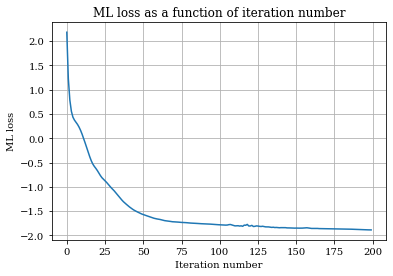

In [9]:
# Load or build & train the model
model_test = generator.RealNVP(s_net, t_net, mask, prior, doublewell, (2,))
optimizer = torch.optim.Adam([p for p in model_test.parameters() if p.requires_grad==True], lr=LR) 
training_set = x_samples.astype('float32')
subdata = data.DataLoader(dataset=training_set, batch_size=batch_size)  # use trainloader.dataset to check the data
batch = torch.from_numpy(subdata.dataset)   # note that subdata.dataset is a numpy array

loss_list = []   # saving the loss as a function of iteration number 
n_iteration = 200
for i in tqdm(range(n_iteration)):
    loss = model_test.loss_ML(batch)
    loss_list.append(loss.item())  # convert from 1-element tensor to scalar

    # start training
    optimizer.zero_grad() # Set grads to zero so that PyTorch will not accumulate gradients during backpropagation
    loss.backward(retain_graph=True)
    optimizer.step()   # check https://tinyurl.com/y8o2y5e7 for more info
    tqdm.write("ML loss: %s" % loss.item(), end="\r")

plt.figure()
plt.plot(range(n_iteration), loss_list)
plt.xlabel('Iteration number')
plt.ylabel('ML loss')
plt.title('ML loss as a function of iteration number')
plt.grid()
plt.savefig('../Project/Pictures/DWP_training_ML_loss.png', dpi=600)

As shown above, the ML loss reach equilibration after about 80 interaions, which indicates that the inverse generator is successfully trained. However, to make sure, we still have to look into the samples generated in the real/configuration space by the generator. 

In [9]:
from scipy.stats import multivariate_normal
def binormal_contour():
    x, y = np.mgrid[-3:3:.01, -3:3:.01]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x; pos[:, :, 1] = y
    rv = multivariate_normal([0, 0], [[1, 0], [0, 1]])
    
    plt.contourf(x, y, rv.pdf(pos), 20)
    plt.xlabel('$ z_{1} $')
    plt.ylabel('$ z_{2} $')
    plt.title('Bivariate normal distribution')
    clb = plt.colorbar()
    clb.ax.set_title(r'$P(z)$')
    
    ax = plt.gca()
    ax.set_aspect('equal')

In [ ]:
fig = plt.subplots(1, 4, figsize=(25, 5))

# First subplot: samples drawn from the configuration space
plt.subplot(1, 4, 1)
doublewell.plot_FES()
plt.scatter(samples1[:, 0], samples1[:, 1], color='red', s=0.5)
plt.scatter(samples2[:, 0], samples2[:, 1], color='silver', s=0.5)
plt.annotate('(configuration space, $ x \sim p(x) $)', xy=(0, 0), xytext=(-4.2, 6.5), color='white', size='12')
ax = plt.gca()
ax.set_aspect(0.58)


# Second subplot: transform configuration samples to latent samples using a trained inversed generator
z1, _, z1_list = model_test.inverse_generator(torch.from_numpy(samples1.astype('float32')), process=True)
z2, _, z2_list = model_test.inverse_generator(torch.from_numpy(samples2.astype('float32')), process=True)
z1 = z1.detach().numpy()
z2 = z2.detach().numpy()

plt.subplot(1, 4, 2)
binormal_contour()
plt.scatter(z1[:, 0], z1[:, 1], color='red', s=0.5)
plt.scatter(z2[:, 0], z2[:, 1], color='silver', s=0.5)
plt.annotate('(latent space, $ z = F_{xz}(x) $)', xy=(0, 0), xytext=(-2.625, 2.4375), color='white', size='12')
plt.xlim([-3, 3])
plt.ylim([-3, 3])


# Third subplot: draw 2000 samples from the prior Gaussian distribution
z_samples = prior.sample_n(5000)
z_samples = z_samples.detach().numpy()  

plt.subplot(1, 4, 3)
binormal_contour()
plt.scatter(z_samples[:, 0], z_samples[:, 1], color='white', s=0.5)
plt.annotate('(latent space, $ z \sim p(z) $)', xy=(0, 0), xytext=(-2.625, 2.4375), color='white', size='12')
plt.xlim([-3, 3])
plt.ylim([-3, 3])

# fourth subplot: transform the latent samples back to the configuration space using a generator
x_generated, _, x_list = model_test.generator(torch.from_numpy(z_samples), process=True)
x_generated = x_generated.detach().numpy()

plt.subplot(1, 4, 4)
doublewell.plot_FES()
plt.scatter(x_generated[:, 0], x_generated[:, 1], color='white', s=0.5)
plt.annotate('(configuration space, $ x = F_{zx}(z) $)', xy=(0, 0), xytext=(-4.2, 6.5), color='white', size='12')
plt.xlim([-5, 5])
plt.ylim([-8, 8])
ax = plt.gca()
ax.set_aspect(0.58)

plt.savefig('../Project/Pictures/DWP_ML_result.png', dpi=600)

In [ ]:
fig = plt.subplots(1, n_blocks + 1, figsize=(25, 4))
titles = ['Input distribution', '1st NVP block', '2nd NVP block', '3rd NVP block, generated samples']

for i in range(n_blocks + 1):
    plt.subplot(1, n_blocks + 1, i + 1)
    binormal_contour()
    plt.scatter(z1_list[i * 2][:, 0], z1_list[i * 2][:, 1], color='red', s=0.5)
    plt.scatter(z2_list[i * 2][:, 0], z2_list[i * 2][:, 1], color='silver', s=0.5)
    plt.annotate('(latent space, $ z = F_{xz}(x) $)', xy=(0, 0), xytext=(-2.625, 2.4375), color='white', size='12')
    plt.xlim([-3, 3])
    plt.ylim([-3, 3])
    
plt.savefig("../Project/Pictures/DWP_ML_tolatent.png", dpi=600)

In [ ]:
x_generated, log_R_zx, x_list = model_ML.generator(torch.from_numpy(z_samples), process=True)
fig = plt.subplots(1, n_blocks + 1, figsize=(25, 4))
#annotate = ['(Input distribution)', '(First block)', '(Second block)', '(Third block, generated samples)']
titles = ['Input distribution', '1st NVP block', '2nd NVP block', '3rd NVP block, generated samples']

for i in range(n_blocks + 1):
    plt.subplot(1, n_blocks + 1, i + 1)
    doublewell.plot_FES()
    plt.scatter(x_list[i * 2][:, 0], x_list[i * 2][:, 1], color='white', s=0.5)
    #plt.annotate(annotate[i], xy=(0, 0), xytext=(-4.2, 6.5), color='white', size='12')
    plt.title(titles[i])
    plt.xlim([-5, 5])
    plt.ylim([-8, 8])
    ax = plt.gca()
    ax.set_aspect(0.58)
    
plt.savefig("../Project/Pictures/DWP_ML_toreal.png", dpi=600)

### Section 4-2. Training by the energy in the latent space

In [ ]:
# Load or build & train the model
model_KL = generator.RealNVP(s_net, t_net, mask, prior, doublewell, (2,))

if os.path.isfile('Trained_models/DoubleWell/model_KL') is True:
    model_KL.load_state_dict(torch.load('Trained_models/DoubleWell/model_KL'))
else:
    optimizer = torch.optim.AdamW([p for p in model_KL.parameters() if p.requires_grad==True], lr=LR, amsgrad=False) 
    z_samples = prior.sample_n(20000).detach().numpy()  
    training_set = z_samples.astype('float32')   # note we use samples in latent space here
    subdata = data.DataLoader(dataset=training_set, batch_size=1000)  # use trainloader.dataset to check the data
    batch = torch.from_numpy(subdata.dataset)   # note that subdata.dataset is a numpy array
    loss_list = []   # saving the loss as a function of iteration number 

    n_iteration = 200
    for i in tqdm(range(n_iteration)):
        loss = model_KL.loss_KL(batch)  # note that batch here are the samples in the latent space!
        loss_list.append(loss.item())  # convert from 1-element tensor to scalar

        # start training
        optimizer.zero_grad() # Set grads to zero so that PyTorch will not accumulate gradients during backpropagation
        loss.backward(retain_graph=True)
        optimizer.step()   # check https://tinyurl.com/y8o2y5e7 for more info
        print("KL loss: %s" % loss.item(), end="\r")

    plt.figure()
    plt.plot(range(n_iteration), loss_list)
    plt.xlabel('Iteration number')
    plt.ylabel('KL loss')
    plt.title('KL loss as a function of iteration number')
    plt.grid()
    plt.savefig('../Project/Pictures/DWP_training_KL_loss.png', dpi=600)

    # Save the trained model
    torch.save(model_KL.state_dict(), 'Trained_models/DoubleWell/model_KL')

In [ ]:
fig = plt.subplots(1, 4, figsize=(25, 5))

# First subplot: samples drawn from the configuration space
plt.subplot(1, 4, 1)
doublewell.plot_FES()
plt.scatter(samples1[:, 0], samples1[:, 1], color='red', s=0.5)
plt.scatter(samples2[:, 0], samples2[:, 1], color='silver', s=0.5)
plt.annotate('(configuration space, $ x \sim p(x) $)', xy=(0, 0), xytext=(-4.2, 6.5), color='white', size='12')
ax = plt.gca()
ax.set_aspect(0.58)


# Second subplot: transform configuration samples to latent samples using a trained inversed generator
z1, _, z1_list = model_KL.inverse_generator(torch.from_numpy(samples1.astype('float32')), process=True)
z2, _, z2_list = model_KL.inverse_generator(torch.from_numpy(samples2.astype('float32')), process=True)
z1 = z1.detach().numpy()
z2 = z2.detach().numpy()

plt.subplot(1, 4, 2)
binormal_contour()
plt.scatter(z1[:, 0], z1[:, 1], color='red', s=0.5)
plt.scatter(z2[:, 0], z2[:, 1], color='silver', s=0.5)
plt.annotate('(latent space, $ z = F_{xz}(x) $)', xy=(0, 0), xytext=(-2.625, 2.4375), color='white', size='12')
plt.xlim([-3, 3])
plt.ylim([-3, 3])


# Third subplot: draw 2000 samples from the prior Gaussian distribution
z_samples = prior.sample_n(2000)
z_samples = z_samples.detach().numpy()  

plt.subplot(1, 4, 3)
binormal_contour()
plt.scatter(z_samples[:, 0], z_samples[:, 1], color='white', s=0.5)
plt.annotate('(latent space, $ z \sim p(z) $)', xy=(0, 0), xytext=(-2.625, 2.4375), color='white', size='12')
plt.xlim([-3, 3])
plt.ylim([-3, 3])

# fourth subplot: transform the latent samples back to the configuration space using a generator
x_generated, log_R_zx = model_KL.generator(torch.from_numpy(z_samples))
x_generated = x_generated.detach().numpy()

plt.subplot(1, 4, 4)
doublewell.plot_FES()
plt.scatter(x_generated[:, 0], x_generated[:, 1], color='white', s=0.5)
plt.annotate('(configuration space, $ x = F_{zx}(z) $)', xy=(0, 0), xytext=(-4.2, 6.5), color='white', size='12')
plt.xlim([-5, 5])
plt.ylim([-8, 8])
ax = plt.gca()
ax.set_aspect(0.58)

plt.savefig('../Project/Pictures/DWP_training_KL_result.png', dpi=600)

In [ ]:
fig = plt.subplots(1, n_blocks + 1, figsize=(25, 4))
titles = ['Input distribution', '1st NVP block', '2nd NVP block', '3rd NVP block, generated samples']

for i in range(n_blocks + 1):
    plt.subplot(1, n_blocks + 1, i + 1)
    binormal_contour()
    plt.scatter(z1_list[i * 2][:, 0], z1_list[i * 2][:, 1], color='red', s=0.5)
    plt.scatter(z2_list[i * 2][:, 0], z2_list[i * 2][:, 1], color='silver', s=0.5)
    plt.annotate('(latent space, $ z = F_{xz}(x) $)', xy=(0, 0), xytext=(-2.625, 2.4375), color='white', size='12')
    plt.xlim([-3, 3])
    plt.ylim([-3, 3])
    
plt.savefig("../Project/Pictures/DWP_KL_tolatent.png", dpi=600)

In [ ]:
x_generated, log_R_zx, x_list = model_KL.generator(torch.from_numpy(z_samples), process=True)
fig = plt.subplots(1, n_blocks + 1, figsize=(25, 4))
#annotate = ['(Input distribution)', '(First block)', '(Second block)', '(Third block, generated samples)']
#titles = ['Input distribution', '1st NVP block', '2nd NVP block', '3rd NVP block, generated samples']

for i in range(n_blocks + 1):
    plt.subplot(1, n_blocks + 1, i + 1)
    doublewell.plot_FES()
    plt.scatter(x_list[i * 2][:, 0], x_list[i * 2][:, 1], color='white', s=0.5)
    #plt.annotate(annotate[i], xy=(0, 0), xytext=(-4.2, 6.5), color='white', size='12')
    #plt.title(titles[i])
    plt.xlim([-5, 5])
    plt.ylim([-8, 8])
    ax = plt.gca()
    ax.set_aspect(0.58)
    
plt.savefig("../Project/Pictures/DWP_KL_toreal.png", dpi=600)

### Section 4-3. Training on ML and KL loss at the same time

In [ ]:
model_MLKL = generator.RealNVP(s_net, t_net, mask, prior, doublewell, (2,))
# Load or build & train the model
model_MLKL = generator.RealNVP(s_net, t_net, mask, prior, doublewell, (2,))

if os.path.isfile('Trained_models/DoubleWell/model_MLKL') is True:
    model_KL.load_state_dict(torch.load('Trained_models/DoubleWell/model_MLKL'))
else:
    optimizer = torch.optim.Adam([p for p in model_MLKL.parameters() if p.requires_grad==True], lr=LR) 
    training_set_x = x_samples.astype('float32')
    training_set_z = z_samples.astype('float32')
    subdata_x = data.DataLoader(dataset=training_set_x, batch_size=batch_size) 
    subdata_z = data.DataLoader(dataset=training_set_z, batch_size=batch_size)  
    batch_x = torch.from_numpy(subdata_x.dataset)   
    batch_z = torch.from_numpy(subdata_z.dataset)
    loss_list = []   # saving the loss as a function of iteration number 
    n_iteration = 200
    for i in tqdm(range(n_iteration)):
        loss_ML = model_MLKL.loss_ML(batch_x)
        loss_KL = model_MLKL.loss_KL(batch_z)
        loss = loss_KL + loss_ML
        loss_list.append(loss.item())  # convert from 1-element tensor to scalar
        # start training
        optimizer.zero_grad() 
        loss.backward(retain_graph=True)
        optimizer.step()   # check https://tinyurl.com/y8o2y5e7 for more info
        print("ML loss: %s" % loss.item(), end="\r")

    plt.figure()
    plt.plot(range(n_iteration), loss_list)
    plt.xlabel('Iteration number')
    plt.ylabel('ML + KL loss')
    plt.title('ML + KL loss as a function of iteration number')
    plt.grid()
    plt.savefig('../Project/Pictures/DWP_training_MLKL_loss.png', dpi=600)

    # Save the trained model
    torch.save(model_MLKL.state_dict(), 'Trained_models/DoubleWell/model_MLKL)

In [ ]:
fig = plt.subplots(1, 4, figsize=(25, 5))

# First subplot: samples drawn from the configuration space
plt.subplot(1, 4, 1)
doublewell.plot_FES()
plt.scatter(samples1[:, 0], samples1[:, 1], color='red', s=0.5)
plt.scatter(samples2[:, 0], samples2[:, 1], color='silver', s=0.5)
plt.annotate('(configuration space, $ x \sim p(x) $)', xy=(0, 0), xytext=(-4.2, 6.5), color='white', size='12')
ax = plt.gca()
ax.set_aspect(0.58)


# Second subplot: transform configuration samples to latent samples using a trained inversed generator
z1 = model_MLKL.inverse_generator(torch.from_numpy(samples1.astype('float32')))[0].detach().numpy()
z2 = model_MLKL.inverse_generator(torch.from_numpy(samples2.astype('float32')))[0].detach().numpy()

plt.subplot(1, 4, 2)
binormal_contour()
plt.scatter(z1[:, 0], z1[:, 1], color='red', s=0.5)
plt.scatter(z2[:, 0], z2[:, 1], color='silver', s=0.5)
plt.annotate('(latent space, $ z = F_{xz}(x) $)', xy=(0, 0), xytext=(-2.625, 2.4375), color='white', size='12')
plt.xlim([-3, 3])
plt.ylim([-3, 3])

# Third subplot: draw 2000 samples from the prior Gaussian distribution
z_samples = prior.sample_n(5000)
z_samples = z_samples.detach().numpy()  

plt.subplot(1, 4, 3)
binormal_contour()
plt.scatter(z_samples[:, 0], z_samples[:, 1], color='white', s=0.5)
plt.annotate('(latent space, $ z \sim p(z) $)', xy=(0, 0), xytext=(-2.625, 2.4375), color='white', size='12')
plt.xlim([-3, 3])
plt.ylim([-3, 3])

# fourth subplot: transform the latent samples back to the configuration space using a generator
x_generated, log_R_zx = model_MLKL.generator(torch.from_numpy(z_samples))
x_generated = x_generated.detach().numpy()

plt.subplot(1, 4, 4)
doublewell.plot_FES()
plt.scatter(x_generated[:, 0], x_generated[:, 1], color='white', s=0.5)
plt.annotate('(configuration space, $ x = F_{zx}(z) $)', xy=(0, 0), xytext=(-4.2, 6.5), color='white', size='12')
plt.xlim([-5, 5])
plt.ylim([-8, 8])
ax = plt.gca()
ax.set_aspect(0.58)

plt.savefig('../Project/Pictures/DWP_training_MLKL_result.png', dpi=600)

### Section 4-3. Training on the total loss (ML + KL + RC)

In [ ]:
model_RC = generator.RealNVP(s_net, t_net, mask, prior, doublewell, (2,))
optimizer = torch.optim.Adam([p for p in model_MLKL.parameters() if p.requires_grad==True], lr=LR) 
training_set_x = x_samples.astype('float32')
training_set_z = z_samples.astype('float32')
subdata_x = data.DataLoader(dataset=training_set_x, batch_size=batch_size) 
subdata_z = data.DataLoader(dataset=training_set_z, batch_size=batch_size)  
batch_x = torch.from_numpy(subdata_x.dataset)   
batch_z = torch.from_numpy(subdata_z.dataset)
loss_list = []   # saving the loss as a function of iteration number 
n_iteration = 200
for i in tqdm(range(n_iteration)):
    loss_ML = model_MLKL.loss_ML(batch_x)
    loss_KL = model_MLKL.loss_KL(batch_z)
    
    loss = loss_KL + loss_ML + loss_RC
    loss_list.append(loss.item())  # convert from 1-element tensor to scalar
    # start training
    optimizer.zero_grad() 
    loss.backward(retain_graph=True)
    optimizer.step()   # check https://tinyurl.com/y8o2y5e7 for more info
    print("ML loss: %s" % loss.item(), end="\r")

plt.figure()
plt.plot(range(n_iteration), loss_list)
plt.xlabel('Iteration number')
plt.ylabel('ML + KL + RC loss')
plt.title('ML + KL + RC loss as a function of iteration number')
plt.grid()
plt.savefig('../Project/Pictures/DWP_training_MLKL_loss.png', dpi=600)

### Section 4-4. Free energy calculations

After confirming that the Boltzmann generator we built was able to generate correct distributions, now we want use it to calculate free energy as a function of reaction coordinate, which is $x_{1}$ in this case. In this toy model, the potential energy is known, meaning that we can calculate the analytical free energy function.

Specifically, by definition, the reduced free energy as a function of a $x_{1}$, can be expressed as $f(x_{1})=-\ln Z(x_{1})$.
To calculate $Z(x_{1})$, we have to integrate the Boltzmann weights over the whole range of $x_{2}$:
$$Z(x_{1}) = \int e ^{-u(x_{1}, x_{2})} dx_{2} = \int^{\infty}_{-\infty} e^{-(x_{1}^{4} - 6x_{1}^{2} + x_{1} + x_{2}^{2})}dx_{2} = e^{-(x_{1}^{4} - 6x_{1}^{2} + x_{1})} \int ^{\infty}_{-\infty}e^{-x_{2}^{2}}dx_{2}=\sqrt{\pi} \cdot e^{-u({x_{1}})}$$
Where $u({x_{1}})=x_{1}^{4} - 6x_{1}^{2} + x_{1}$.

Therefore, $f=-\ln Z(x_{1}) = u(x_{1}) - \ln(\sqrt{\pi}) = x_{1}^{4} - 6x_{1}^{2} + x_{1} - \ln(\sqrt{\pi})$

In practice, to validate that the Boltzmann generator is able to perform free energy calculation, we follow the steps as shown below:
- **Step 1**: 


Specifically, the reduced free energy of the system can be calculated as:$f=-\ln p(x) + \text{constant}$, where $\text{constant}$ is actually $\ln Z_{x}$. Since we are only able to calculate energy differences rather than the absolute difference,  shifting the minimum of the free energy to 0 (so that the constant is 0) would give $f=\ln p(x)$. 

In [9]:
from scipy.stats import multivariate_normal
def binormal_contour():
    x, y = np.mgrid[-3:3:.01, -3:3:.01]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x; pos[:, :, 1] = y
    rv = multivariate_normal([0, 0], [[1, 0], [0, 1]])
    
    plt.contourf(x, y, rv.pdf(pos), 20)
    plt.xlabel('$ z_{1} $')
    plt.ylabel('$ z_{2} $')
    plt.title('Bivariate normal distribution')
    clb = plt.colorbar()
    clb.ax.set_title(r'$P(z)$')
    
    ax = plt.gca()
    ax.set_aspect('equal')

## ML model
### 1. Using weighted histogram

s =  tensor([[-0.3868, -0.5737],
        [-0.5892,  0.4150],
        [-0.5880, -0.1430],
        [ 0.0852, -0.5400],
        [ 0.4941,  0.4677]], grad_fn=<SliceBackward>)
t =  tensor([[ 0.3643, -0.3121],
        [-0.1371,  0.3319],
        [-0.6657,  0.4241],
        [-0.1455,  0.3597],
        [ 0.0983, -0.0866]], grad_fn=<SliceBackward>)
Loading the trained model ...
Total loss: -1.6430611610412598


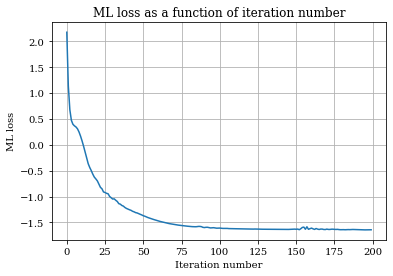

In [7]:
params_ML = {"n_blocks": 3, "dimension": 2, "n_nodes": 100, "n_layers": 3,
               "n_iterations": 200, "batch_size": 1000, "LR": 0.001, "prior_sigma": 1}
w_loss = [1, 0, 0]

# for drawing samples from the latent space later
prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2)) 

BoltzmannGenerator_ML = training.BoltzmannGenerator(model_params=params_ML)
model_ML = BoltzmannGenerator_ML.build(doublewell)
if os.path.isfile('Trained_models/DoubleWell/model_ML') is True:  
    print("Loading the trained model ...")
    model_ML, loss = BoltzmannGenerator_ML.load(model_ML, 'Trained_models/DoubleWell/model_ML')
else:   
    print("Training model_ML ...")
    BoltzmannGenerator_ML.train(model_ML, w_loss, x_samples=x_samples)
    BoltzmannGenerator_ML.save(model_ML, 'Trained_models/DoubleWell/model_ML')
    loss = BoltzmannGenerator_ML.loss_list
    
# plot the loss function as a function of iteration
plt.figure()
plt.plot(range(len(loss)), loss)
plt.xlabel('Iteration number')
plt.ylabel('ML loss')
plt.title('ML loss as a function of iteration number')
plt.grid()
plt.savefig('../Project/Pictures/DWP_training_ML_loss.png', dpi=600)

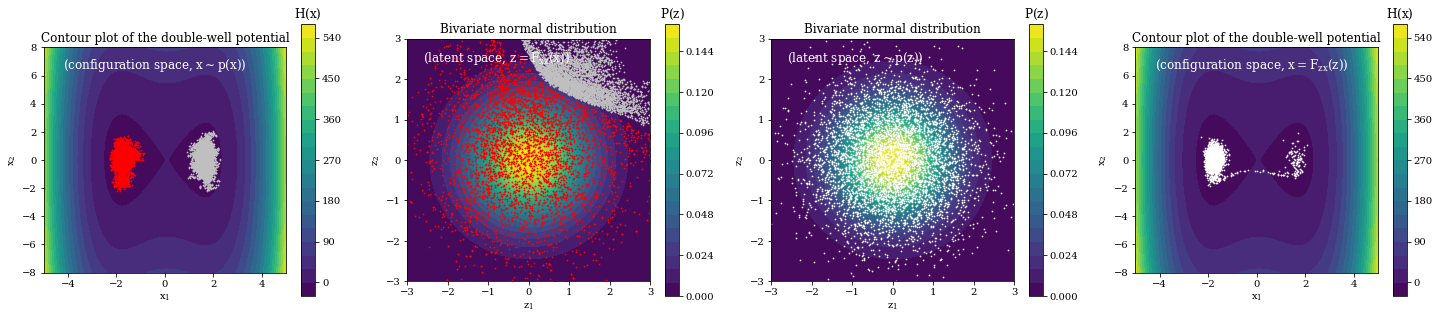

In [10]:
fig = plt.subplots(1, 4, figsize=(25, 5))

# First subplot: samples drawn from the configuration space
plt.subplot(1, 4, 1)
doublewell.plot_FES()
plt.scatter(samples1[:, 0], samples1[:, 1], color='red', s=0.5)
plt.scatter(samples2[:, 0], samples2[:, 1], color='silver', s=0.5)
plt.annotate('(configuration space, $ x \sim p(x) $)', xy=(0, 0), xytext=(-4.2, 6.5), color='white', size='12')
ax = plt.gca()
ax.set_aspect(0.58)


# Second subplot: transform configuration samples to latent samples using a trained inversed generator
z1, _, z1_list = model_ML.inverse_generator(torch.from_numpy(samples1.astype('float32')), process=True)
z2, _, z2_list = model_ML.inverse_generator(torch.from_numpy(samples2.astype('float32')), process=True)
z1 = z1.detach().numpy()
z2 = z2.detach().numpy()

plt.subplot(1, 4, 2)
binormal_contour()
plt.scatter(z1[:, 0], z1[:, 1], color='red', s=0.5)
plt.scatter(z2[:, 0], z2[:, 1], color='silver', s=0.5)
plt.annotate('(latent space, $ z = F_{xz}(x) $)', xy=(0, 0), xytext=(-2.625, 2.4375), color='white', size='12')
plt.xlim([-3, 3])
plt.ylim([-3, 3])


# Third subplot: draw 2000 samples from the prior Gaussian distribution
z_samples = prior.sample_n(5000)
z_samples = z_samples.detach().numpy()  

plt.subplot(1, 4, 3)
binormal_contour()
plt.scatter(z_samples[:, 0], z_samples[:, 1], color='white', s=0.5)
plt.annotate('(latent space, $ z \sim p(z) $)', xy=(0, 0), xytext=(-2.625, 2.4375), color='white', size='12')
plt.xlim([-3, 3])
plt.ylim([-3, 3])

# fourth subplot: transform the latent samples back to the configuration space using a generator
x_generated, _, x_list = model_ML.generator(torch.from_numpy(z_samples), process=True)
x_generated = x_generated.detach().numpy()

plt.subplot(1, 4, 4)
doublewell.plot_FES()
plt.scatter(x_generated[:, 0], x_generated[:, 1], color='white', s=0.5)
plt.annotate('(configuration space, $ x = F_{zx}(z) $)', xy=(0, 0), xytext=(-4.2, 6.5), color='white', size='12')
plt.xlim([-5, 5])
plt.ylim([-8, 8])
ax = plt.gca()
ax.set_aspect(0.58)

plt.savefig('../Project/Pictures/DWP_ML_result.png', dpi=600)

In [11]:
z_f = prior.sample_n(100000)
x_f, log_R_zx = model_ML.generator((z_f))
x_f = x_f.detach().numpy()

In [12]:
u_x = model_ML.calculate_energy(torch.from_numpy(x_f), space='configuration')
u_z = model_ML.calculate_energy(z_f, space='latent')
w = torch.exp(-u_x + u_z + log_R_zx)
w = w.detach().numpy()

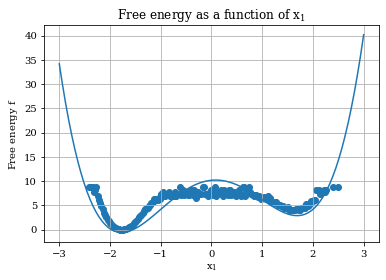

In [13]:
counts, bins = np.histogram(x_f[:, 0], bins=200)
probs = counts / np.sum(counts)  # p_x(x)
centers = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])  # x

f = -np.log(probs)
f -= np.min(f)

plt.figure()
plt.scatter(centers, f)
plt.xlabel("$x_{1}$")
plt.ylabel("Free energy $f$")
plt.title("Free energy as a function of $x_{1}$")
plt.grid()
#doublewell.plot_section(y=0)

x1  = np.linspace(-3, 3, 100)
f_analytical = doublewell.get_energy([x1, 0]) - np.log(np.sqrt(np.pi))
f_analytical -= doublewell.get_energy([-1.7723034076580755, 0.0])
plt.plot(x1, f_analytical)
plt.savefig('../Project/Pictures/DWP_free_energy_unweighted.png', dpi=600)

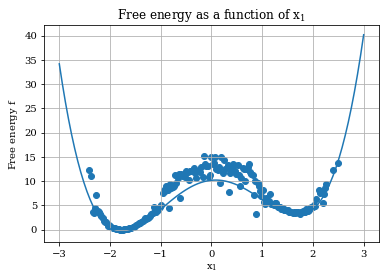

In [14]:
counts, bins = np.histogram(x_f[:, 0], bins=200, weights=w)
probs = counts / np.sum(counts)  # p_x(x)
centers = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])  # x

f = -np.log(probs)
f -= np.min(f)

plt.figure()
plt.scatter(centers, f)
plt.xlabel("$x_{1}$")
plt.ylabel("Free energy $f$")
plt.title("Free energy as a function of $x_{1}$")
plt.grid()
#doublewell.plot_section(y=0)

x1  = np.linspace(-3, 3, 100)
f_analytical = doublewell.get_energy([x1, 0]) - np.log(np.sqrt(np.pi))
f_analytical -= doublewell.get_energy([-1.7723034076580755, 0.0])
plt.plot(x1, f_analytical)
plt.savefig('../Project/Pictures/DWP_free_energy_reweighted.png', dpi=600)

### 2. Using KDE

In [158]:
from Library.density_estimator import density_estimator
z_f = prior.sample_n(1000)
x_f, log_R_zx = model_ML.generator((z_f))
x_f = x_f.detach().numpy()

u_x = model_ML.calculate_energy(torch.from_numpy(x_f), space='configuration')
u_z = model_ML.calculate_energy(z_f, space='latent')
w = torch.exp(-u_x + u_z + log_R_zx)
w = w.detach().numpy()

In [161]:
x_range = np.linspace(-3, 3, len(x_f[:, 0] - 1))
p, log_p = density_estimator(x_f[:, 0], x_range, w, optimize=False)

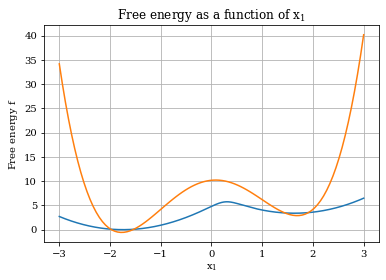

In [162]:
f = -log_p
f -= np.min(f)

plt.figure()
plt.plot(x_range, f)
plt.xlabel("$x_{1}$")
plt.ylabel("Free energy $f$")
plt.title("Free energy as a function of $x_{1}$")
plt.grid()
#doublewell.plot_section(y=0)

x1  = np.linspace(-3, 3, 100)
f_analytical = doublewell.get_energy([x1, 0]) - np.log(np.sqrt(np.pi))
f_analytical -= doublewell.get_energy([-1.7723034076580755, 0.0])
plt.plot(x1, f_analytical)

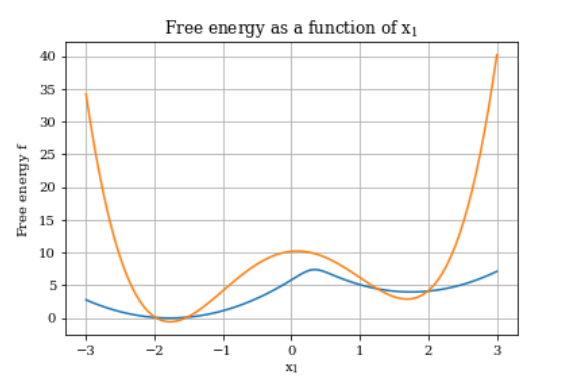

## KL model

In [ ]:
z_f = prior.sample_n(100000)
x_f, log_R_zx = model_KL.generator((z_f))
x_f = x_f.detach().numpy()

In [ ]:
u_x = model_KL.calculate_energy(torch.from_numpy(x_f), space='configuration')
u_z = model_KL.calculate_energy(z_f, space='latent')
w = torch.exp(-u_x + u_z + log_R_zx)
w = w.detach().numpy()

In [ ]:
counts, bins = np.histogram(x_f[:, 0], bins=200)
probs = counts / np.sum(counts)  # p_x(x)
centers = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])  # x

f = -np.log(probs)
f -= np.min(f)

plt.figure()
plt.scatter(centers, f)
plt.xlabel("$x_{1}$")
plt.ylabel("Free energy $f$")
plt.title("Free energy as a function of $x_{1}$")
plt.grid()
#doublewell.plot_section(y=0)

x1  = np.linspace(-3, 3, 100)
f_analytical = doublewell.get_energy([x1, 0]) - np.log(np.sqrt(np.pi))
f_analytical -= doublewell.get_energy([-1.7723034076580755, 0.0])
plt.plot(x1, f_analytical)
plt.savefig('../Project/Pictures/DWP_free_energy_KL_unweighted.png', dpi=600)

In [ ]:
counts, bins = np.histogram(x_f[:, 0], bins=200, weights=w)
probs = counts / np.sum(counts)  # p_x(x)
centers = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])  # x

f = -np.log(probs)
f -= np.min(f)

plt.figure()
plt.scatter(centers, f)
plt.xlabel("$x_{1}$")
plt.ylabel("Free energy $f$")
plt.title("Free energy as a function of $x_{1}$")
plt.grid()
#doublewell.plot_section(y=0)

x1  = np.linspace(-3, 3, 100)
f_analytical = doublewell.get_energy([x1, 0]) - np.log(np.sqrt(np.pi))
f_analytical -= doublewell.get_energy([-1.7723034076580755, 0.0])
plt.plot(x1, f_analytical)
plt.savefig('../Project/Pictures/DWP_free_energy_KL_reweighted.png', dpi=600)

## MLKL model

In [ ]:
z_f = prior.sample_n(100000)
x_f, log_R_zx = model_MLKL.generator((z_f))
x_f = x_f.detach().numpy()

In [ ]:
u_x = model_MLKL.calculate_energy(torch.from_numpy(x_f), space='configuration')
u_z = model_MLKL.calculate_energy(z_f, space='latent')
w = torch.exp(-u_x + u_z + log_R_zx)
w = w.detach().numpy()

In [ ]:
counts, bins = np.histogram(x_f[:, 0], bins=200)
probs = counts / np.sum(counts)  # p_x(x)
centers = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])  # x

f = -np.log(probs)
f -= np.min(f)

plt.figure()
plt.scatter(centers, f)
plt.xlabel("$x_{1}$")
plt.ylabel("Free energy $f$")
plt.title("Free energy as a function of $x_{1}$")
plt.grid()
#doublewell.plot_section(y=0)

x1  = np.linspace(-3, 3, 100)
f_analytical = doublewell.get_energy([x1, 0]) - np.log(np.sqrt(np.pi))
f_analytical -= doublewell.get_energy([-1.7723034076580755, 0.0])
plt.plot(x1, f_analytical)
plt.savefig('../Project/Pictures/DWP_free_energy_MLKL_unweighted.png', dpi=600)

In [ ]:
counts, bins = np.histogram(x_f[:, 0], bins=200, weights=w)
probs = counts / np.sum(counts)  # p_x(x)
centers = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])  # x

f = -np.log(probs)
f -= np.min(f)

plt.figure()
plt.scatter(centers, f)
plt.xlabel("$x_{1}$")
plt.ylabel("Free energy $f$")
plt.title("Free energy as a function of $x_{1}$")
plt.grid()
#doublewell.plot_section(y=0)

x1  = np.linspace(-3, 3, 100)
f_analytical = doublewell.get_energy([x1, 0]) - np.log(np.sqrt(np.pi))
f_analytical -= doublewell.get_energy([-1.7723034076580755, 0.0])
plt.plot(x1, f_analytical)
plt.savefig('../Project/Pictures/DWP_free_energy_MLKL_reweighted.png', dpi=600)

In [17]:
from Library.density_estimator import density_estimator
z_f = prior.sample_n(100)
x_f, log_R_zx = model_ML.generator((z_f))
x_f = x_f.detach().numpy()

u_x = model_ML.calculate_energy(torch.from_numpy(x_f), space='configuration')
u_z = model_ML.calculate_energy(z_f, space='latent')
w = torch.exp(-u_x + u_z + log_R_zx)
w = w.detach().numpy()

In [20]:
x_range = np.linspace(-3, 3, len(x_f[:, 0] - 1))
p, log_p = density_estimator(x_f[:, 0], x_range.reshape(-1, 1), w, optimize=True)

ValueError: sample_weight must have positive values

In [ ]:
f = -log_p
f -= np.min(f)

plt.figure()
plt.plot(x_range, f)
plt.xlabel("$x_{1}$")
plt.ylabel("Free energy $f$")
plt.title("Free energy as a function of $x_{1}$")
plt.grid()
#doublewell.plot_section(y=0)

x1  = np.linspace(-3, 0, 100)
f_analytical = doublewell.get_energy([x1, 0]) - np.log(np.sqrt(np.pi))
f_analytical -= doublewell.get_energy([-1.7723034076580755, 0.0])
plt.plot(x1, f_analytical)
plt.savefig('../Project/Pictures/DWP_free_energy_MLKL_reweighted.png', dpi=600)

In [ ]:
x_range = np.linspace(-3, 0, len(x_f[:, 0] - 1))
p, log_p = density_estimator(x_f[:, 0], x_range.reshape(-1, 1))

## Section 5.  Free energy calculations of double-well potential
With our model now correctly generating the Boltzmann distribution (bottom right), we can utilize it to calculate the free energy as a function of the reaction coordinate for this system (the coordinate $x_1$). The Boltzmann distribution is given by:
$p(x) = \exp(-f(x))$ so $f = -\log(p(x))$ where $f$ denote free energy. 

Steps:

1) Histogram the obtained samples to estimate probs

2) Filter probabilities to avoid single-sample, low-prob. states that are likely just noise

3) Calculate free energy

4) Shift free energy to lowest well reference state (we only get relative $f - f_0$)


Note: The smoothness of the average can be improved by generating more sample points.

Parameters to try
- Different masking schemes
- Different activation functions in each layer of the neural networks (s_net and t_net).
- Whether to use an activation function in the output layer.


## References